# Use of `minisom` package to train SOM

__Source:__ https://glowingpython.blogspot.com/2013/09/self-organizing-maps.html

Adaptation of the above code to the OCR dataset used in the TME course.

### Read the dataset

In [27]:
import numpy as np

data_x = np.loadtxt('OCR.txt', delimiter=",", usecols=range(1,17),
         dtype=np.float64)

# normalization to unity of each pattern in the data
data_x = np.apply_along_axis(lambda x: x/np.linalg.norm(x),1,data_x)

### Train the SOM

In [28]:
from minisom import MiniSom

Ntypes = 26              # Number of classes
Rows = 100; Cols = 100    # Size of SOM map
Nfeatures = 16           # Number of features

# Create SOM: x-size, y-size, n-inputs, Spread of the neighborhood function, learning rate
som = MiniSom(Rows,Cols,Nfeatures,sigma=2.0,learning_rate=1)

# Initialize weights
som.random_weights_init(data_x)

# Train
print("Training...")
som.train_random(data_x,5000) # training (give number of iterations)
print("\n...ready!")

Training...

...ready!


### VIsualize U-map

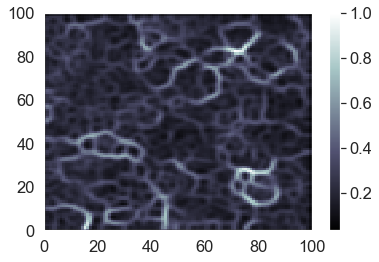

In [29]:
%matplotlib inline
from pylab import plot,axis,show,pcolor,colorbar,bone

bone()
pcolor(som.distance_map().T) # distance map as background
colorbar()

axis([0,som.get_weights().shape[0],0,som.get_weights().shape[1]])
show() # show the figure

Associating each data label to one map node 


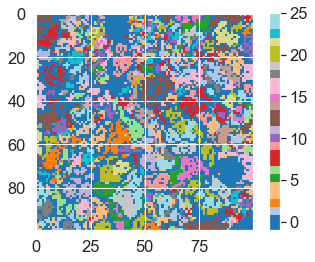

In [30]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Determine most common value in a list. Used to 
# determine the label of a neuron by finding its most
# common response in a list of labels
def most_common(lst, n):
    # lst is a list of values 0 . . n
    if len(lst) == 0: return -1
    counts = np.zeros(shape=n, dtype=np.int)
    for i in range(len(lst)):
        counts[lst[i]] += 1
    return np.argmax(counts)

# ==================================================================

# Read labels from file
# data_y = np.genfromtxt('6-gaussianes.txt',delimiter=',',usecols=(3),dtype=int)
data_y = np.loadtxt('OCR.txt', delimiter=",", usecols=(0),dtype=int)

# 4. because the data has labels, another possible visualization:
# associate each data label with a map node
print("Associating each data label to one map node ")
mapping = np.empty(shape=(Rows,Cols), dtype=object)
for i in range(Rows):
    for j in range(Cols):
        mapping[i][j] = []

for i in range(len(data_x)):
    (m_row, m_col) = som.winner(data_x[i]) # getting the winner
    mapping[m_row][m_col].append(data_y[i])

label_map = np.zeros(shape=(Rows,Cols), dtype=np.int)
for i in range(Rows):
    for j in range(Cols):
        label_map[i][j] = most_common(mapping[i][j], Ntypes)

plt.imshow(label_map, cmap=plt.cm.get_cmap('tab20', Ntypes+1))
plt.colorbar()
plt.show()

In [31]:
total= 0
correct= 0
for i in range(len(data_x)):
    
    # Select winning neuron
    row, col = som.winner(data_x[i])
    
    # Collect classification from label map and compare
    if data_y[i]==label_map[row][col]:
        correct+=1
    total+=1
    
print("Total:  ", total)
print("Correct: {:d} ({:.2f}%)".format(correct,100.*correct/total))

Total:   20000
Correct: 18738 (93.69%)


### Confusion matrix

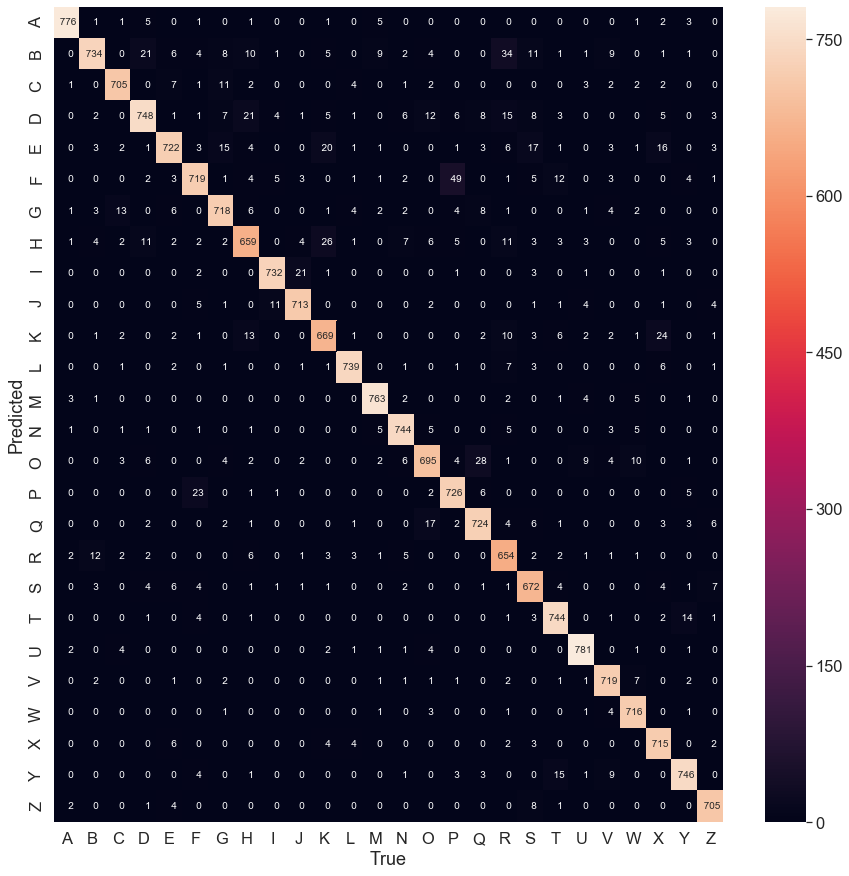

In [32]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate list of true-predicted letter codes
true= data_y

pred= []
for i in range(len(data_x)):
    
    # Select winning neuron
    row, col = som.winner(data_x[i])
    
    # Collect classification from label
    pred.append(label_map[row][col])

# Generate confusion matrix
CM= confusion_matrix(pred,true)

# Plot heatmap
df_cm = pd.DataFrame(CM, range(Ntypes), range(Ntypes))
t_labels= [ chr(val+65) for val in range(0,Ntypes)]

plt.figure(figsize=(15,15))

sn.set(font_scale=1.5) # for label size
HM= sn.heatmap(df_cm, annot=True, annot_kws={"size":10}, fmt="4d")
HM.set_yticklabels(t_labels)
HM.set_xticklabels(t_labels)

# Patch to avoid cut in top/bottom; see https://github.com/mwaskom/seaborn/issues/1773
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()
